# Create a hierarchical mixed model for RT prediction of lipids using statsmodels
## Compare to PyMC3 bayesian version of same problem (which takes forever to train) 

In [168]:
import json
import warnings
import os 
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from src.parse_lipid import parse_lipid

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import mean_squared_error

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile, parse_int=True)
    
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Can't use the filtered dataset because most of the FAs have been removed
# Also don't use the Final Results output, use the Unfiltered Results 
# data = pd.read_csv('../data/processed/lipidomics_linregress_normalized_data.csv')
data = pd.read_csv(r'../data/search/CD31/peak_finder/Unfiltered_Results.csv')
data.rename({'Quant Ion': 'm/z', 'Retention Time (min)': 'RT', 'Identification': 'ID', 
             'Area (max)': 'Area (Max.)'}, inplace=True, axis=1)
data.rename({fr_name: mod_name for fr_name, mod_name in zip(fg['fr_name'], fg.index)}, inplace=True, axis=1)
data_cols = data.filter(regex='\d_RBG|\d_FBG').columns
data['mean'] = data[data_cols].mean(axis=1)
data['is_id'] = data['ID'].notna()
data.drop(data.filter(regex='Unnamed').columns, axis=1, inplace=True)

data

,RT,m/z,Polarity,Area (Max.),ID,Lipid Class,Features Found,Filter Status,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),...,1102_8_RBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),mean,is_id
0,0.528,664.07684,+,7.218670e+06,NaN,NaN,2,Dimer,3616.600742,3754.897464,...,2.456581e+06,4.949765e+06,3.271367e+06,3.898191e+06,3.586652e+06,4371.310119,3837.969412,3872.151793,3.856685e+06,False
1,0.529,662.08582,+,2.056865e+07,NaN,NaN,4,Dimer,4138.791646,4297.056647,...,1.187316e+07,1.415339e+07,5.295644e+06,9.765149e+06,1.210703e+07,5002.471406,4392.123121,4457.358249,1.244037e+07,False
2,0.530,991.11859,+,9.722884e+06,NaN,NaN,6,Adduct of existing peak,5222.040196,5421.727995,...,5.513680e+06,5.899307e+06,7.166797e+06,5.926878e+06,6.104699e+06,6484.218919,5541.676278,5623.985437,5.649135e+06,False
3,0.531,661.08264,+,7.778703e+07,NaN,NaN,44,Dimer,4970.354146,5160.417616,...,3.948893e+07,4.646823e+07,6.052133e+07,4.309350e+07,4.116755e+07,6171.699792,5274.584766,5352.926881,4.544072e+07,False
4,0.532,659.06866,-,6.691758e+07,NaN,NaN,47,Dimer,28520.354100,6130.634650,...,4.258937e+07,3.593391e+07,5.412068e+07,4.535156e+07,4.205162e+07,9011.421356,6850.520434,6319.495392,3.674949e+07,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,20.434,967.86713,+,3.380837e+06,NaN,NaN,4,Adduct of existing identified peak,12843.405760,13979.736960,...,7.847792e+05,2.203746e+05,1.180822e+06,3.224706e+05,5.614904e+05,23499.690490,14932.771020,18051.601980,5.087279e+05,False
3134,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,NaN,12695.823470,13819.097200,...,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830,4.847183e+05,False
3135,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,NaN,13749.188890,14296.409340,...,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230,3.069704e+05,False
3136,20.473,936.89600,+,2.627972e+06,TG 56:0,TG,6,RT out of class range,12059.809380,12539.792190,...,7.020718e+05,4.570013e+05,1.062921e+06,7.064462e+05,6.040003e+05,101141.455400,13090.673690,19330.809740,6.323672e+05,True


# Massage data into correct form 
1. Filter members of lipid class
2. Assign Carbon and FA 

In [155]:
data['C'] = data['ID'].map((lambda x: parse_lipid(x)[2]))#.astype('category')
data['unsat'] = data['ID'].map((lambda x: parse_lipid(x)[3]))#.astype('category')
data['C_cat'] = data['C'].astype('category')
data['unsat_cat'] = data['unsat'].astype('category')
data = data[['RT', 'Lipid Class', 'ID', 'C', 'unsat', 'C_cat', 'unsat_cat']].dropna()
data

,RT,Lipid Class,ID,C,unsat,C_cat,unsat_cat
255,0.891,LysoPI,LysoPI 20:4,20.0,4.0,20.0,4.0
275,0.938,AC,AC 14:1,14.0,1.0,14.0,1.0
282,1.036,LysoPC,LysoPC 20:5,20.0,5.0,20.0,5.0
287,1.086,LysoPC,LysoPC 16:0,16.0,0.0,16.0,0.0
292,1.095,LysoPC,LysoPC 16:0,16.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...
3112,19.876,TG,TG 58:2,58.0,2.0,58.0,2.0
3116,19.885,TG,TG 18:0_18:0_18:0,54.0,0.0,54.0,0.0
3130,20.429,TG,TG 60:2,60.0,2.0,60.0,2.0
3132,20.434,TG,TG 16:0_18:1_24:0,58.0,1.0,58.0,1.0


In [150]:
tg = df.loc[df['Lipid Class'] == 'TG']
tg = tg.loc[tg['unsat'] < 19]
tg['C_cat'] = tg['C'].astype('category')
tg['unsat_cat'] = tg['unsat'].astype('category')


me.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:              MixedLM Dependent Variable: RT      
No. Observations:   175     Method:             REML    
No. Groups:         17      Scale:              0.0446  
Min. group size:    1       Log-Likelihood:     -42.8505
Max. group size:    25      Converged:          Yes     
Mean group size:    10.3                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -5.440    0.878 -6.193 0.000 -7.162 -3.719
C              0.372    0.006 61.316 0.000  0.361  0.384
unsat_cat Var 11.071   19.473                           
========================================================

"""

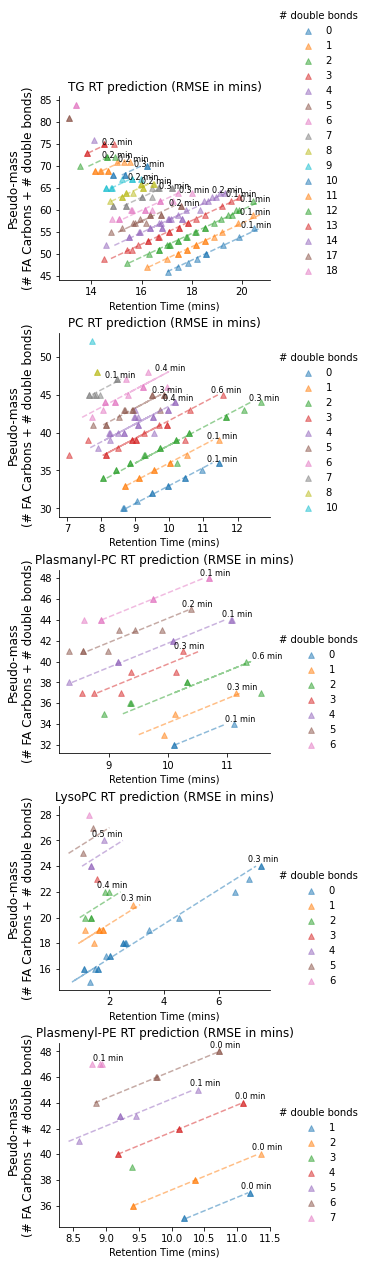

In [174]:
lipid_classes = data['Lipid Class'].value_counts().index[0:5]
fig, axs = plt.subplots(nrows=len(lipid_classes), figsize=(5, 3.5*len(lipid_classes)), constrained_layout=True)

for i, cls in enumerate(lipid_classes):
    df = data.loc[data['Lipid Class'] == cls]
    try:
        with warnings.catch_warnings(record=True) as model_warning:
            me = smf.mixedlm(f'RT ~ C', data=df, groups='unsat_cat').fit(reml=True)
            if model_warning:
                print(f'Warning for {cls}')
    except:
        print(cls, 'skipped')
        continue
    main_intercept = me.params['Intercept']
    C_coef = me.params['C']
    ax = axs[i]
    for unsat in sorted(df['unsat'].unique()):
        Cs = df.loc[df['unsat'] == unsat, 'C'].values
        intercept = main_intercept + me.random_effects[unsat].iloc[0]
        # RT will be on x-axis by convention, even though it's being predicted
        rt_pred = (Cs * C_coef) + intercept
        rt_true = df.loc[(df['unsat'] == unsat) & (df['C'].isin(Cs)), 'RT']
        mzs = Cs + unsat
        ax.plot(rt_pred, mzs, '--', alpha=0.5)
        ax.scatter(rt_true, mzs, marker='^', s=33, alpha=0.5, label=int(unsat))
        if len(rt_pred) > 2:
            rmse = np.sqrt(mean_squared_error(y_true=rt_true, y_pred=rt_pred))
            ax.text(s=f'{round(rmse, 1)} min', x=max(rt_true)+0.1, y=max(mzs)+0.5, 
                    fontsize=8, ha='center', va='center')
    ax.set_xlabel('Retention Time (mins)')
    ax.set_ylabel('Pseudo-mass\n(# FA Carbons + # double bonds)', fontsize=12)
    ax.set_title(f'{cls} RT prediction (RMSE in mins)', )
    ax.legend(loc=(1.02, 0.0), title='# double bonds', frameon=False)
sns.despine()

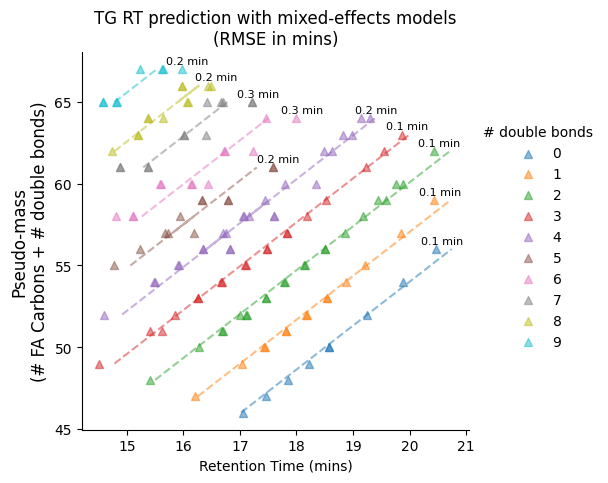

In [145]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

main_intercept = me.params['Intercept']
C_coef = me.params['C']

for unsat in sorted(tg['unsat'].unique())[:10]:
    Cs = tg.loc[tg['unsat'] == unsat, 'C'].values
    intercept = main_intercept + me.random_effects[unsat].iloc[0]
    # RT will be on x-axis by convention, even though it's being predicted
    rt_pred = (Cs * C_coef) + intercept
    rt_true = tg.loc[(tg['unsat'] == unsat) & (tg['C'].isin(Cs)), 'RT']
    mzs = Cs + unsat
    ax.plot(rt_pred, mzs, '--', alpha=0.5)
    ax.scatter(rt_true, mzs, marker='^', s=33, alpha=0.5, label=int(unsat))
    rmse = np.sqrt(mean_squared_error(y_true=rt_true, y_pred=rt_pred))
    ax.text(s=f'{round(rmse, 1)} min', x=max(rt_true)+0.1, y=max(mzs)+0.5, fontsize=8, ha='center', va='center')
ax.set_xlabel('Retention Time (mins)')
ax.set_ylabel('Pseudo-mass\n(# FA Carbons + # double bonds)', fontsize=12)
ax.set_title('TG RT prediction with mixed-effects models\n(RMSE in mins)', )
ax.legend(loc=(1.02, 0.2), title='# double bonds', frameon=False)
sns.despine()

In [83]:
me.random_effects

{0.0: unsat_cat    5.325665
 dtype: float64,
 1.0: unsat_cat    4.563157
 dtype: float64,
 2.0: unsat_cat    3.806054
 dtype: float64,
 3.0: unsat_cat    3.087483
 dtype: float64,
 4.0: unsat_cat    2.477692
 dtype: float64,
 5.0: unsat_cat    1.879538
 dtype: float64,
 6.0: unsat_cat    1.335397
 dtype: float64,
 7.0: unsat_cat    0.61464
 dtype: float64,
 8.0: unsat_cat    0.108237
 dtype: float64,
 9.0: unsat_cat   -0.63714
 dtype: float64,
 10.0: unsat_cat   -0.951103
 dtype: float64,
 11.0: unsat_cat   -1.725469
 dtype: float64,
 12.0: unsat_cat   -2.281085
 dtype: float64,
 13.0: unsat_cat   -3.042777
 dtype: float64,
 14.0: unsat_cat   -3.523605
 dtype: float64,
 17.0: unsat_cat   -5.294075
 dtype: float64,
 18.0: unsat_cat   -5.742609
 dtype: float64}

In [77]:
me.params

Intercept     -5.440260
C              0.372469
unsat Var    248.155460
dtype: float64

In [78]:
me.fe_params

Intercept   -5.440260
C            0.372469
dtype: float64

In [38]:
me.

True

In [ ]:
with warnings.catch_warnings(record=True) as warning_gluc_tol:
            no_gluc_tol = smf.mixedlm(f'{f} ~            bg_type', df, groups=df['animal']).fit(maxiter=50, reml=False)